In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
prediction_path = '/root/autodl-tmp/cervical_spine/predictions/axial_detection_effdet_081553_predictions.csv'

In [3]:
columns = ['UID'] + [f'P{i}' for i in range(8)] + ['loss','loss_pos','loss_neg'] + [f'C{i}' for i in range(8)] 
patient_pred_df = pd.read_csv(prediction_path, names=columns)

patient_pred_df

,UID,P0,P1,P2,P3,P4,P5,P6,P7,loss,loss_pos,loss_neg,C0,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,0.160988,0.017133,0.160988,0.040924,0.010000,0.010000,0.043105,0.020319,0.110571,0.000000,0.110571,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10005,0.274719,0.020440,0.042654,0.030749,0.025184,0.051258,0.061614,0.274719,0.200483,0.000000,0.200483,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10014,0.314104,0.010000,0.010000,0.010000,0.010000,0.314104,0.049468,0.042793,0.225065,0.000000,0.225065,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.10016,0.148235,0.035814,0.027754,0.030204,0.010000,0.112619,0.148235,0.031190,1.558315,2.118383,0.064800,1,0,1,0,0,0,0,0
4,1.2.826.0.1.3680043.10032,0.359564,0.031287,0.024039,0.010000,0.359564,0.010000,0.084875,0.169044,0.279638,0.000000,0.279638,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,1.2.826.0.1.3680043.9926,0.998806,0.977110,0.998806,0.041930,0.303998,0.205648,0.356305,0.076501,0.225081,0.001195,0.822109,1,0,1,0,0,0,0,0
2008,1.2.826.0.1.3680043.9940,0.999000,0.028908,0.016485,0.999000,0.999000,0.398760,0.014402,0.068597,0.386699,0.103044,1.407856,1,0,0,0,1,1,0,0
2009,1.2.826.0.1.3680043.9994,0.521198,0.521198,0.405718,0.027770,0.016820,0.061861,0.118498,0.067926,0.479829,0.000000,0.479829,0,0,0,0,0,0,0,0
2010,1.2.826.0.1.3680043.9996,0.477006,0.046066,0.477006,0.059835,0.020712,0.144561,0.225421,0.064564,0.565988,0.740227,0.101352,1,0,1,0,0,0,0,0


In [4]:
# patient_pred_df = pd.read_csv('/root/autodl-tmp/df_patient_pred_7945.csv',header = 0, names=['StudyInstanceUID'] + [f'P{i}' for i in range(8)]).set_index('StudyInstanceUID')
# label_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv')).set_index('StudyInstanceUID')
# # patient_pred_df.rename(columns = {"patient_overall" : "UID"}, inplace = True)

# label_df.rename(columns = {"patient_overall" : "C0"}, inplace = True)
# patient_pred_df = pd.concat((patient_pred_df, label_df), axis=1)
# patient_pred_df = patient_pred_df[~pd.isna(patient_pred_df['P0'])]
# patient_pred_df

In [11]:
def cal_loss(prob, label):
    
    pos_weight = np.array([14, 2, 2, 2, 2, 2, 2, 2])
    neg_weight = np.array([7, 1, 1, 1, 1, 1, 1, 1])
    
    score = pos_weight * label * np.log(prob) + neg_weight * (1 - label) * np.log(1 - prob)
    
    weight_total = pos_weight * label + neg_weight * (1 - label)
    
    scores = -score.sum(axis=1) / weight_total.sum(axis=1)
    return np.mean(scores)

In [12]:
prob = patient_pred_df[[f'P{i}' for i in range(8)]].values
label = patient_pred_df[[f'C{i}' for i in range(8)]].values

In [13]:
loss = cal_loss(prob, label)
print('baseline:', loss)

baseline: 0.31456759655005884


min loss: 0.31456759655005884


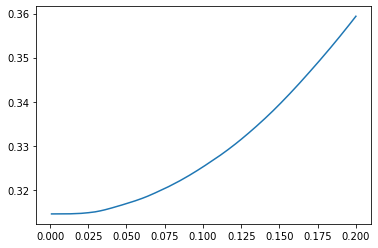

In [14]:
# only clip lower bound
losses = []

clips = np.linspace(0.001, 0.2, 1000)
for clip in clips:
    new_prob = np.clip(prob, a_min=clip, a_max=1)
    loss= cal_loss(new_prob, label)
    
    losses.append(loss)
print('min loss:', np.min(losses))
plt.plot(clips, losses)

min loss: 0.3108030917823775 index: 118 clip: 0.02450550550550551


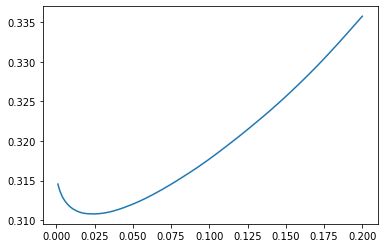

In [23]:
# clip upper
losses = []

clips = np.linspace(0.001, 0.2, 1000)
for clip in clips:
    new_prob = np.clip(prob, a_min=0, a_max=1-clip)
    loss= cal_loss(new_prob, label)
    
    losses.append(loss)
print('min loss:', np.min(losses), 'index:', np.argmin(losses), 'clip:', clips[np.argmin(losses)])
plt.plot(clips, losses)

In [25]:
# clip both
losses = []

lin_count=1000
min_clips = np.linspace(0.001, 0.2, lin_count)
max_clips = np.linspace(0.001, 0.2, lin_count)

for min_clip in tqdm(min_clips):
    
    for max_clip in max_clips:
        new_prob = np.clip(prob, a_min=min_clip, a_max=1-max_clip)
        loss= cal_loss(new_prob, label)
    
        losses.append(loss)
print('min loss:', np.min(losses))

In [29]:
argmin = np.asarray(losses).argmin()
argmin

118

In [31]:
lin_count=1000
argmin = np.asarray(losses).argmin()
min_index = argmin // lin_count
max_index = argmin % lin_count
print(f'min clip index:{min_index} value:{min_clips[min_index]} max clip index:{max_index} value:{max_clips[max_index]}')
# plt.plot(clips, losses)

min clip index:0 value:0.001 max clip index:118 value:0.02450550550550551


In [26]:
new_prob = np.clip(prob, a_min=min_clips[min_index], a_max=1-max_clips[max_index])
loss= cal_loss(new_prob, label)
print("optimal:", loss)

optimal: 0.3108030917823775
